### Loading and examining data

In [1]:
import scipy.constants
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.base import clone

In [2]:
df = pd.read_csv('merged_data_sub_10.csv')
df.shape # before cleaning

(4262, 58)

In [3]:
thresh = len(df) * 0.05 # drop column if missing values in more than 95% of rows
df = df.dropna(thresh=thresh, axis = 1)
thresh2 = 20 # drop rows with < 20 non-missing
df = df.dropna(thresh=thresh2, axis=0)

In [4]:
df.shape

(4262, 58)

In [5]:
print(df.columns)

Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'SDMVPSU',
       'SDMVSTRA', 'WTMEC4YR', 'SDDSRVYR', 'RIDSTATR', 'LBXSAL', 'LBDSALSI',
       'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI', 'LBXSCA',
       'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL',
       'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH', 'LBDSPHSI',
       'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR', 'LBDSTRSI',
       'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI', 'LBXSCLSI',
       'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI', 'LBXLH',
       'LBDLHSI', 'SSCYPC', 'WTSCY4YR', 'LBXSCR', 'eGFR', 'eGFR_no_race',
       'change_in_eGFR', 'eGFRcys', 'change_in_eGFR_cys', 'simulated_mGFR'],
      dtype='object')


In [6]:
# Further preparing the data 
# Drop irrelevant columns
columns_to_drop = ["SDMVPSU", "SDMVSTRA", "WTMEC4YR", "SDDSRVYR", "RIDSTATR", "WTSCY4YR", "eGFR", "eGFR_no_race", "change_in_eGFR"]
df = df.drop(columns=columns_to_drop)
# Encode categorical variables
label_encoders = {}
for column in ["RIAGENDR", "RIDRETH2", "RIDEXPRG"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# separating and printing shapes
labeled_data = df[df['simulated_mGFR'].notna()]
unlabeled_data = df[df['simulated_mGFR'].isna()]

X_labeled = labeled_data.drop(columns=['simulated_mGFR'])
y_labeled = labeled_data['simulated_mGFR']
X_unlabeled = unlabeled_data.drop(columns=['simulated_mGFR'])

print(X_labeled.shape, y_labeled.shape, X_unlabeled.shape)
print(X_labeled.columns)

(426, 48) (426,) (3836, 48)
Index(['SEQN', 'RIDEXPRG', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH2', 'LBXSAL',
       'LBDSALSI', 'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI',
       'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI',
       'LBXSGL', 'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH',
       'LBDSPHSI', 'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR',
       'LBDSTRSI', 'LBXSUA', 'LBDSUASI', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI',
       'LBXSCLSI', 'LBXSOSSI', 'LBXSGB', 'LBDSGBSI', 'LBXFSH', 'LBDFSHSI',
       'LBXLH', 'LBDLHSI', 'SSCYPC', 'LBXSCR', 'eGFRcys',
       'change_in_eGFR_cys'],
      dtype='object')


### Self training: trains regressor on labeled data, then predicts on unlabeled data. Adds confident predictions from unlabeled data to the labeled dataset. Repeat iteratively for defined number of iterations or until no further predictions are found. Vs. pseudolabeling: augments initial training set once with single pass through the test data-- can also be iterative but no measure of confidence?

In [7]:
y_labeled = y_labeled.to_numpy()
X_train_labeled, X_test_labeled, y_train_labeled, y_test_unlabeled = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

In [8]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [25, 50, 100, 200, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
print("hi")

# XGBoost, grid search and 5 fold CV
xgb_regressor = xgb.XGBRegressor()
grid_search = RandomizedSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_labeled, y_train_labeled)

best_xgb_regressor = grid_search.best_estimator_

hi


In [ ]:
# reference: https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/
def self_training_regressor(X_labeled, y_labeled, X_unlabeled, base_regressor, threshold=0.8, max_iter=10):
    model = clone(base_regressor)
    for iteration in range(max_iter):
        # Train the model (best_xbg_regression) on the labeled data
        model.fit(X_labeled, y_labeled)
        
        # Predict on the unlabeled data
        y_unlabeled_pred = model.predict(X_unlabeled)
        
        # get unlabeled predictions past a certain threshold/confidence to the labeled data 
        # for regression, closest to mean prediction?
        confidence = np.abs(y_unlabeled_pred - np.mean(y_labeled)) / np.std(y_labeled)
        confident_indices = np.where(confidence <= threshold)[0]
        
        if len(confident_indices) == 0:
            break
        
        # Add the confident predictions to the labeled dataset
        X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[confident_indices]], ignore_index=True)
        y_labeled = np.concatenate([y_labeled, y_unlabeled_pred[confident_indices]])
        
        # remove those same confident predictions from the unlabeled dataset
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[confident_indices]).reset_index(drop=True)
        
        print(f'Iteration {iteration+1}: Added {len(confident_indices)} confident predictions to the labeled dataset.')
        
    return model

# Apply self-training
final_model = self_training_regressor(X_train_labeled, y_train_labeled, X_unlabeled, best_xgb_regressor)


In [30]:
# Evaluate on the validation set
y_val_pred = best_xgb_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_val_pred)
print(f'Mean Squared Error on validation set: {mse}')

Mean Squared Error on validation set: 286.7549763249766


In [31]:
start_time = time.time()
xgb_regressor.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.07134485244751 seconds ---


In [32]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("stdv:", scores.std())

from sklearn.model_selection import cross_val_score
start_time = time.time()
score = cross_val_score(xgb_regressor, X_train, y_train,
                         scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
xbg_mae_scores = -score
display_scores(xbg_mae_scores)
print("--- %s seconds ---" % (time.time() - start_time))

Scores: [15.38695769 15.93331503 15.45517171 15.79149273 16.90677523]
Mean: 15.894742478813573
stdv: 0.5454221265777986
--- 2.9301810264587402 seconds ---


In [33]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, xgb_regressor.predict(X_test))

13.992450181674052

In [34]:
from sklearn.metrics import r2_score
r2_score(y_test, xgb_regressor.predict(X_test))

0.5811893307133584

Text(0, 0.5, 'Count')

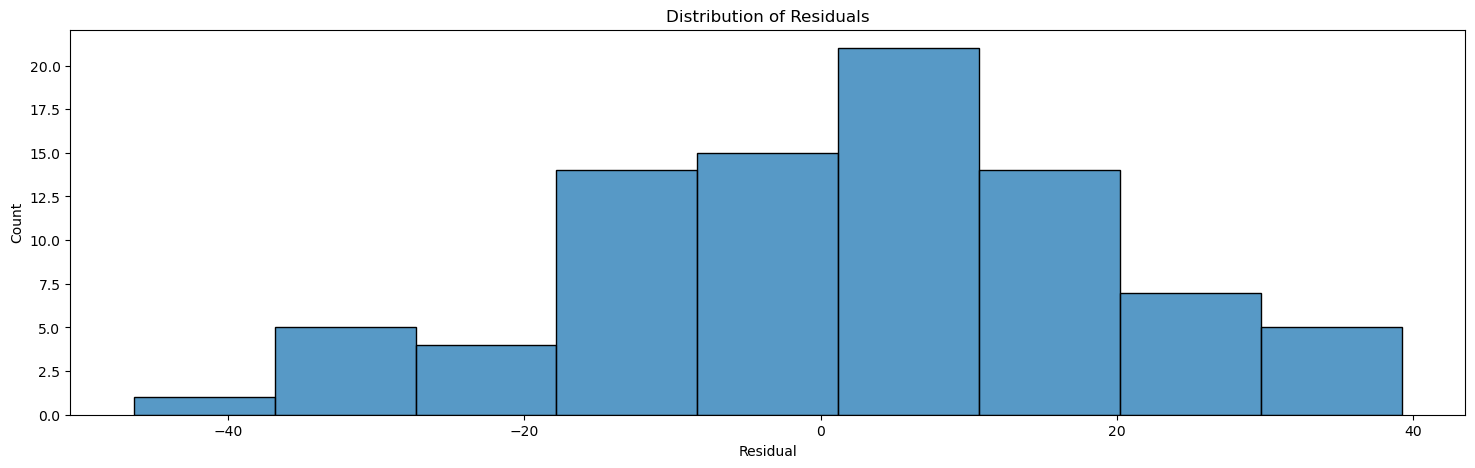

In [35]:
xbg_preds = xgb_regressor.predict(X_test)
actuals = y_test
resids = xbg_preds - actuals
plt.figure(figsize=(18,5))
sns.histplot(resids);
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')

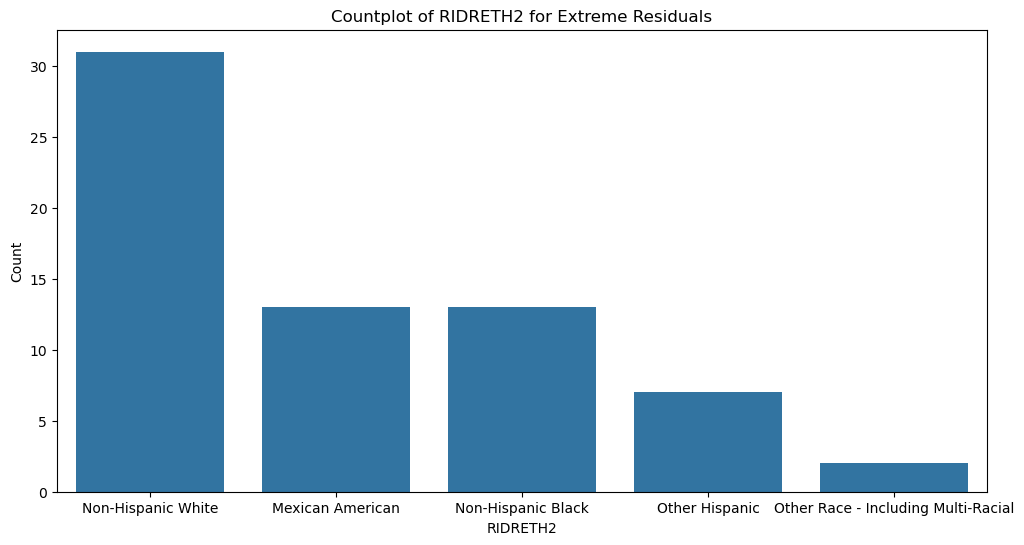

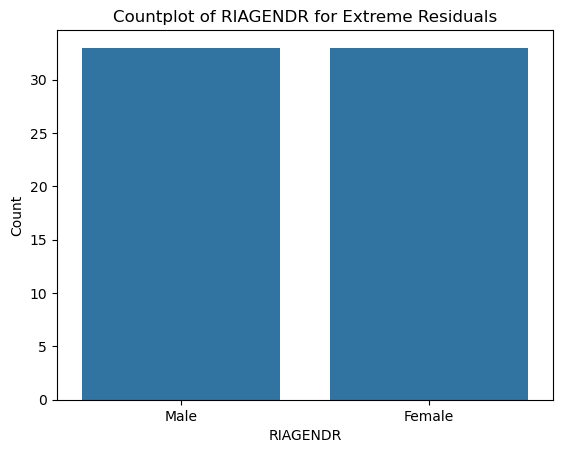

In [36]:
# turn y_test into Pandas series so can index
y_test_series = pd.Series(y_test, index=df.index[:len(y_test)])

# Convert residuals to a pandas Series with the same index
resids_series = pd.Series(resids, index=y_test_series.index)

# Filter the indices where residuals are less than -5 or greater than 5 
filtered_indices = resids_series[(resids_series < -5) | (resids_series > 5)].index
df['RIDRETH2_decoded'] = label_encoders['RIDRETH2'].inverse_transform(df['RIDRETH2'])
df['RIAGENDR_decoded'] = label_encoders['RIAGENDR'].inverse_transform(df['RIAGENDR'])
plt.figure(figsize=(12, 6))
sns.countplot(data=df.loc[filtered_indices], x='RIDRETH2_decoded')
plt.title('Countplot of RIDRETH2 for Extreme Residuals')
plt.xlabel('RIDRETH2')
plt.ylabel('Count')
plt.show()

sns.countplot(data=df.loc[filtered_indices], x='RIAGENDR_decoded')
plt.title('Countplot of RIAGENDR for Extreme Residuals')
plt.xlabel('RIAGENDR')
plt.ylabel('Count')
plt.show()


/var/folders/6p/6161x96942x8rv20mn8nby2r0000gn/T/ipykernel_39214/1513536409.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');


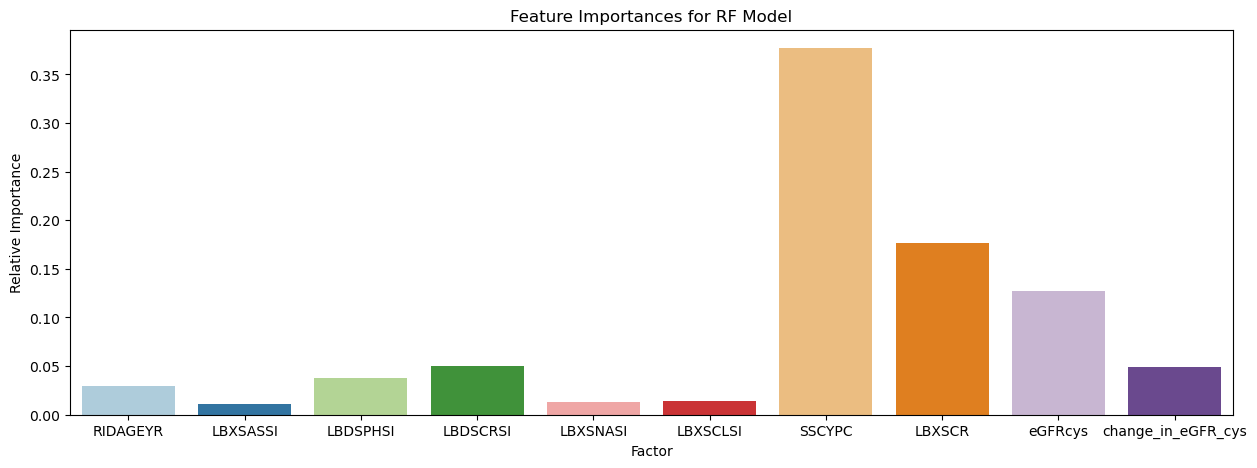

In [37]:
varimp = []
for name, score in zip(X_labeled.columns, xgb_regressor.feature_importances_):
    if score >= 0.01:
        varimp.append((name, score))

varimpdf = pd.DataFrame(varimp)

d = {'Factor': varimpdf[0], 'Relative Importance': varimpdf[1]}
varimps = pd.DataFrame(data=d)

plt.figure(figsize=(15,5))
plt.title("Feature Importances for RF Model")
sns.barplot(x = varimps.Factor, y=varimps['Relative Importance'], palette='Paired');

In [38]:
varimps.sort_values(by = 'Relative Importance', ascending=False)


,Factor,Relative Importance
6,SSCYPC,0.377353
7,LBXSCR,0.176348
8,eGFRcys,0.127111
3,LBDSCRSI,0.049806
9,change_in_eGFR_cys,0.048458
2,LBDSPHSI,0.038139
0,RIDAGEYR,0.029503
5,LBXSCLSI,0.014043
4,LBXSNASI,0.012756
1,LBXSASSI,0.010634


Text(0, 0.5, 'Actual Values')

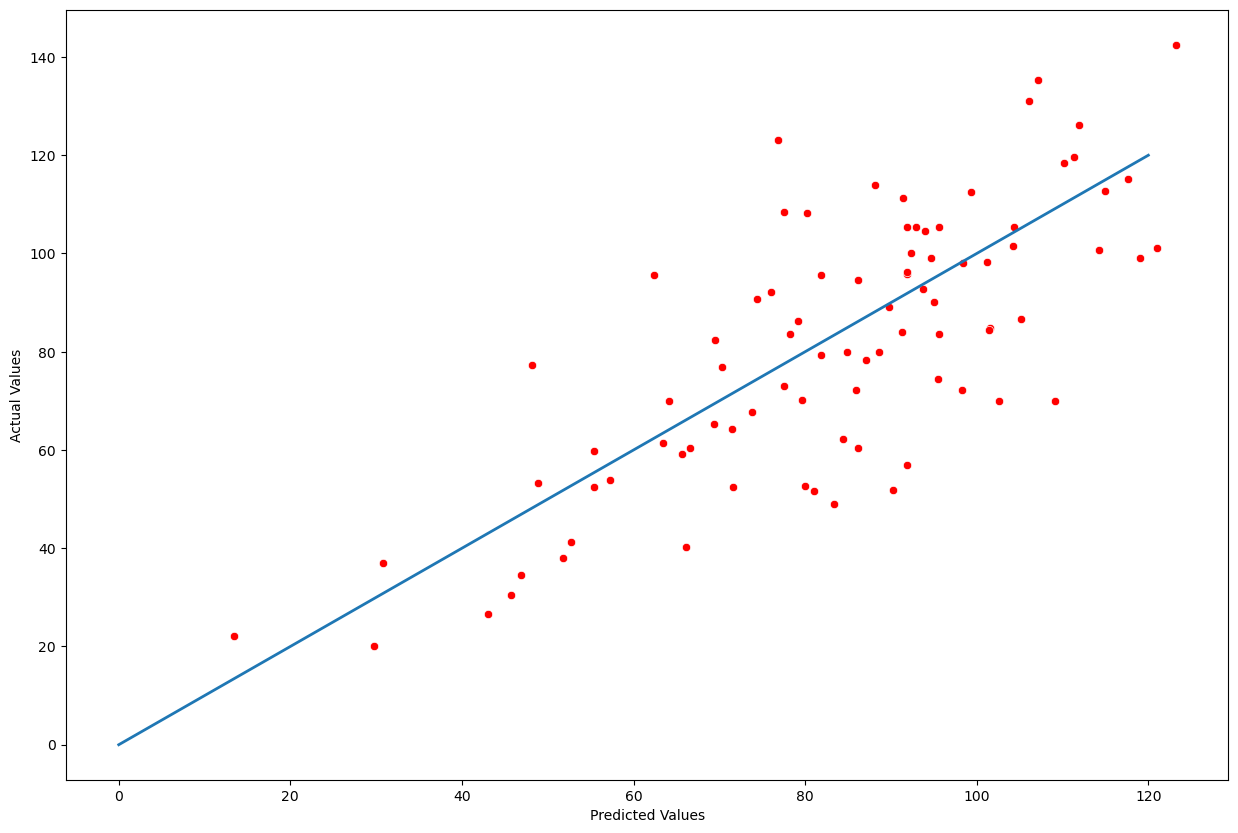

In [39]:
plt.figure(figsize=(15, 10));
sns.scatterplot(x=xgb_regressor.predict(X_test), y=y_test, color="red");
plt.plot([0, 120], [0, 120], linewidth=2);
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")